In [ ]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('fivethirtyeight')

print ('import completed')

import completed


In [ ]:

Enrol_window = 250
print ('enrol window set to', Enrol_window )

enrol window set to 250


In [ ]:
# Support functions

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data


def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]



def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


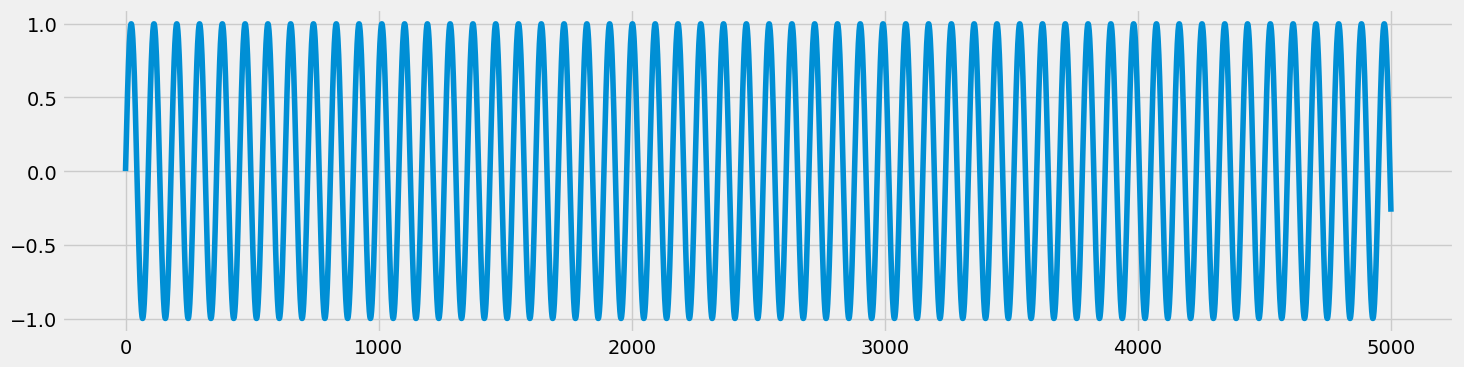

In [ ]:
# Generate data

def mySine(x, T=90):
    return np.sin(x/T * 2*np.pi)

xxArray = np.arange(0, 5000, 1)
dataset = pd.DataFrame(mySine(xxArray), columns=['Wave'])

plt.figure(figsize=(16,4))
plt.plot(dataset)
plt.show()

In [ ]:
feature_train, label_train, feature_test, label_test = load_data(dataset, 'Wave', Enrol_window, False)

print ('Datasets generated')

Datasets generated


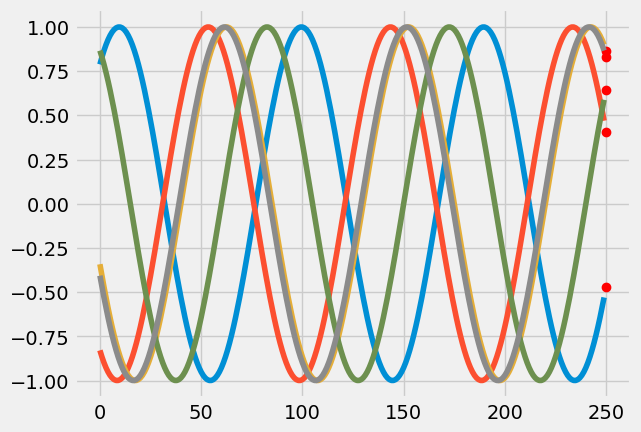

In [ ]:
for sety,y in zip(feature_train[:10],label_train[:5]):
    plt.plot(sety)
    plt.plot(len(sety),y,'ro')

plt.show()

In [ ]:
# The LSTM model I would like to test

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')
print (model.summary())

model compiled
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 250, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 70901 (276.96 KB)
Trainable params: 70901 (276.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Non

In [ ]:
#Train the model
from tensorflow.keras.callbacks import EarlyStopping
callback_ES = [EarlyStopping(verbose=True, patience=10, monitor='val_loss')]

history = model.fit(feature_train, label_train, batch_size=64, epochs=50, validation_data = (feature_test, label_test), callbacks=callback_ES, verbose=1)

Epoch 1/50
67/67 [==============================] - 19s 32ms/step - loss: 0.0540 - val_loss: 4.2316e-04
Epoch 2/50
67/67 [==============================] - 1s 19ms/step - loss: 0.0040 - val_loss: 1.0359e-04
Epoch 3/50
67/67 [==============================] - 1s 19ms/step - loss: 0.0035 - val_loss: 1.4024e-04
Epoch 4/50
67/67 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 5.0819e-04
Epoch 5/50
67/67 [==============================] - 2s 23ms/step - loss: 0.0031 - val_loss: 8.1933e-04
Epoch 6/50
67/67 [==============================] - 2s 28ms/step - loss: 0.0026 - val_loss: 2.5173e-04
Epoch 7/50
67/67 [==============================] - 1s 20ms/step - loss: 0.0027 - val_loss: 8.5664e-04
Epoch 8/50
67/67 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 4.2796e-05
Epoch 9/50
67/67 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 3.5925e-04
Epoch 10/50
67/67 [==============================] - 1s 19ms/step - loss

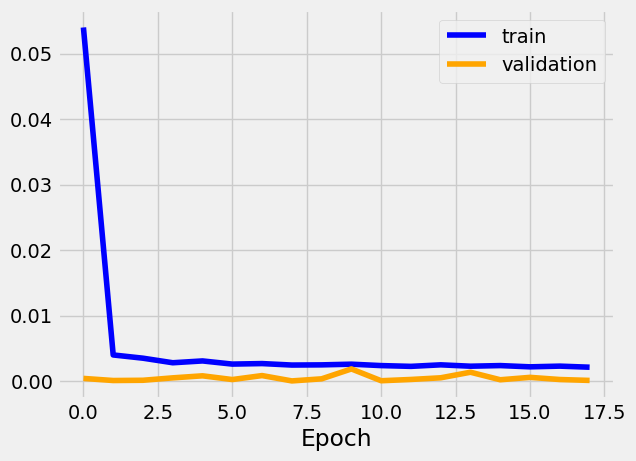

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot loss
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.clf()

# save plot to file
plt.show()
plt.clf()

In [ ]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []

    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [ ]:
#Let's use the model and predict the wave
predictions= predict_sequence_full(model, feature_test, Enrol_window)

1/1 [==============================] - 0s 22ms/step


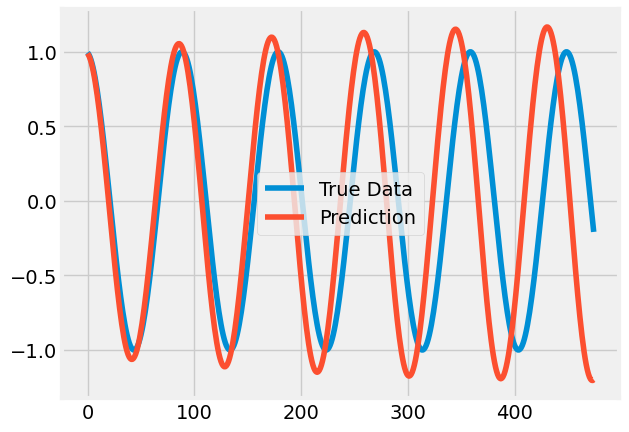

In [ ]:
plot_results(predictions,label_test)